In [4]:
import numpy as np
import tensorflow.keras
from PIL import Image

import matplotlib.pyplot as plt

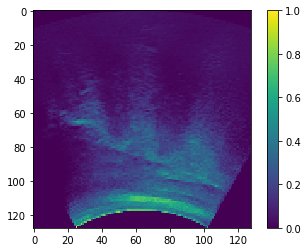

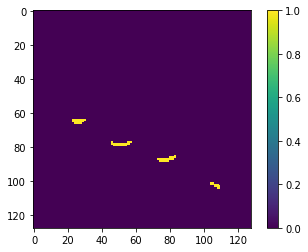

In [30]:
import os
def array_from_folder(path):
    pics = os.listdir(path)
    pics.sort()
    pics = [np.array(Image.open(os.path.join(path, p))) for p in pics]
    pics = np.array(pics)
    return pics

# Download this dataset using the notebook DownloadSpineSegmentationData
train_inputs = array_from_folder("SpineSegmentationData/training/ultrasounds/") / 255.
train_outputs = array_from_folder("SpineSegmentationData/training/segmentations/") / 255.

test_inputs = array_from_folder("SpineSegmentationData/testing/ultrasounds/") / 255.
test_outputs = np.expand_dims(array_from_folder("SpineSegmentationData/testing/segmentations/"), -1) / 255.

#poor man's one hot encoding
test_outputs = np.concatenate([test_outputs, 1-test_outputs], -1)

plt.imshow(train_inputs[0])
plt.colorbar()
plt.show()

plt.imshow(train_outputs[0])
plt.colorbar()
plt.show()


In [49]:
import scipy.ndimage
augmented_inputs  = []
augmented_outputs = []

for i in range(6):
    dx = np.random.randint(-15, 15)
    dy = np.random.randint(-15, 15)
    augmented_inputs.append(scipy.ndimage.shift(train_inputs, (0, dx, dy), order=0))
    augmented_outputs.append(scipy.ndimage.shift(train_outputs, (0, dx, dy), order=0))

augmented_inputs = np.concatenate(augmented_inputs)
augmented_inputs = np.expand_dims(augmented_inputs, axis=-1)
augmented_outputs = np.expand_dims(np.concatenate(augmented_outputs), axis=-1)
#poor man's one hot encoding
augmented_outputs = np.concatenate([augmented_outputs, 1-augmented_outputs], -1)


test_inputs_augmented = np.expand_dims(test_inputs, axis=-1)


In [47]:

from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def nvidia_unet(patch_size=128, num_classes=2, num_input_channels=1):
    input_ = Input((patch_size, patch_size, num_input_channels))
    skips = []
    output = input_
    c = num_classes
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [c*8, c*16, c*32, c*32, c*32, c*32, c*32]):
        skips.append(output)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
    
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [c*32, c*32, c*32, c*32, c*16, c*8, c]):
        output = UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != c:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters, (shape, shape), activation=activation, padding="same")(output)
        if filters != c:
            output = BatchNormalization(momentum=.9)(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

model = nvidia_unet()

model.compile(optimizer="adam",
               loss= "binary_crossentropy",
               metrics=["accuracy"])


In [50]:
loss_curve = model.fit(augmented_inputs, 
              augmented_outputs,
              batch_size=64,
              epochs=30,
              verbose=1,
              validation_data=(test_inputs_augmented, test_outputs))



Train on 19740 samples, validate on 1892 samples
Epoch 1/30
19740/19740 [==============================] - 25s 1ms/step - loss: 0.4741 - acc: 0.9972 - val_loss: 0.5495 - val_acc: 0.9973
Epoch 2/30
19740/19740 [==============================] - 21s 1ms/step - loss: 0.4502 - acc: 0.9973 - val_loss: 0.6443 - val_acc: 0.9973
Epoch 3/30
19740/19740 [==============================] - 23s 1ms/step - loss: 0.4352 - acc: 0.9973 - val_loss: 0.5921 - val_acc: 0.9974
Epoch 4/30
19740/19740 [==============================] - 23s 1ms/step - loss: 0.4233 - acc: 0.9974 - val_loss: 0.6053 - val_acc: 0.9974
Epoch 5/30
19740/19740 [==============================] - 24s 1ms/step - loss: 0.4110 - acc: 0.9974 - val_loss: 0.5427 - val_acc: 0.9974
Epoch 6/30
19740/19740 [==============================] - 24s 1ms/step - loss: 0.4013 - acc: 0.9975 - val_loss: 0.6425 - val_acc: 0.9973
Epoch 7/30
19740/19740 [==============================] - 24s 1ms/step - loss: 0.3925 - acc: 0.9975 - val_loss: 0.6948 - val_acc:

KeyboardInterrupt: 

In [12]:
print("unique name of training run for logging:")
save_name = input()
save_dir = "runs/" + save_name
import os
import shutil
os.mkdir(save_dir)


model.save(save_dir + "/final_weights")

pickle.dump(loss_curve.history, open("runs/" + save_name + "/loss_"+ str(loss_curve.history["val_loss"][-1]) + ".pickle", "wb"))


unique name of training run for logging:
zero_mean


In [51]:
out = model.predict(test_inputs_augmented)

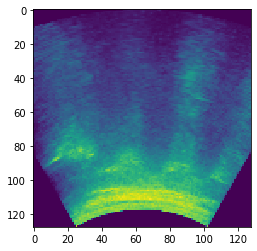

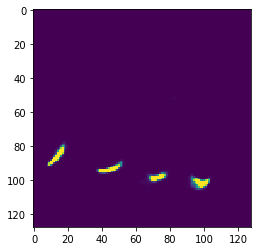

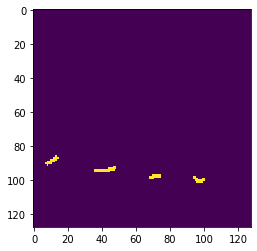

In [83]:
j = np.random.randint(500)

plt.imshow(test_inputs_augmented[j, :, :, 0])
plt.show()

plt.imshow(out[j, :, :, 0] * 3, vmax=1) # *3 == haxx
plt.show()

plt.imshow(test_outputs[j, :, :, 0])
plt.show()

In [59]:
plt.imshow?